# Mount Drive and import PyTorch

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# # http://pytorch.org/
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 484.0MB 49.4MB/s 
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.49 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.


# Problem 1 - Using a pre-trained CNN

## Part 1 - Using pre-trained deep CNN

In [1]:
# Loading packages and pre-trained model with classes
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torch
import json

resnet18 = models.resnet18(pretrained=True).eval()
with open('drive/Deep Learning/HW2/imagenet_class_index.json') as data_file:    
    class_idx = json.load(data_file)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:04, 9805262.22it/s] 


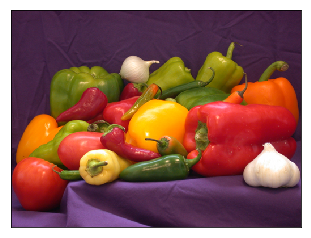

Top probabilities:
   1 )  bell_pepper  [ 95.846 %]
   2 )  cucumber  [ 1.353 %]
   3 )  orange  [ 0.503 %]


In [0]:
image = Image.open("drive/Deep Learning/HW2/hw2/peppers.jpg")
import matplotlib.pyplot as plt

plt.imshow(image)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


def get_array(tensor):
  return tensor.detach().numpy()[()]

img_tensor = transform(image)
predicted = resnet18(img_tensor.unsqueeze(0))
probs = torch.nn.functional.softmax(predicted, dim=1)
top_prob,top_index = torch.topk(probs.squeeze(),3)
print("Top probabilities:")
for i in range(3):
  index = get_array(top_index[i])
  print("  ",i+1,") ",class_idx[str(index)][1],
        " [",round(get_array(top_prob[i])*100,3),"%]")


## Part 2 - Visualizing Feature Maps

image:  1


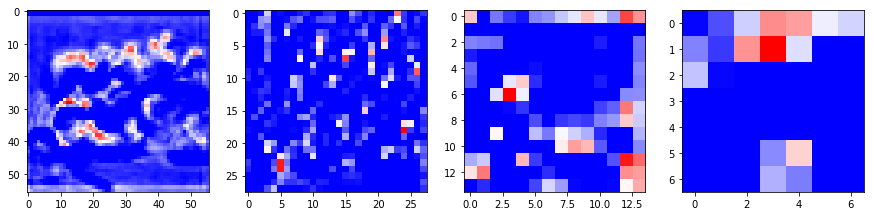

image:  19


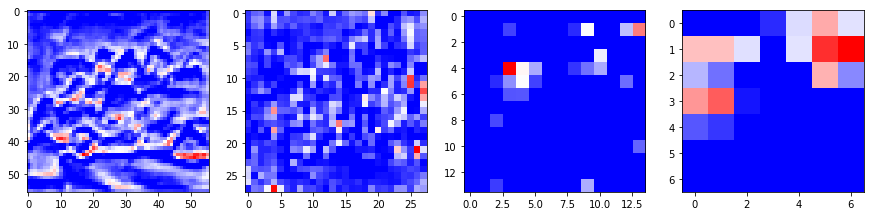

image:  22


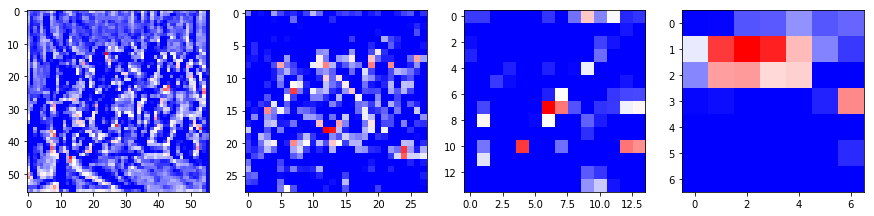

image:  48


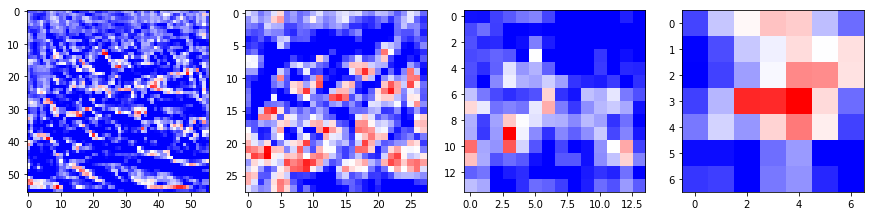

image:  55


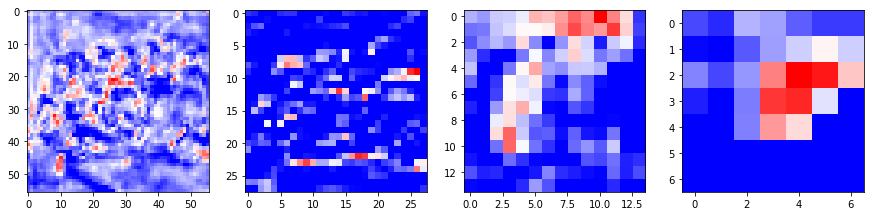

In [0]:
# get_activation function from:
# https://discuss.pytorch.org/t/
#   extract-features-from-layer-of-submodule-of-a-model/20181

activation = {}
def get_activation(name):
    def hook(resnet18, input, output):
        activation[name] = output.detach()
    return hook

resnet18.layer1.register_forward_hook(get_activation('layer1'))
resnet18.layer2.register_forward_hook(get_activation('layer2'))
resnet18.layer3.register_forward_hook(get_activation('layer3'))
resnet18.layer4.register_forward_hook(get_activation('layer4'))

output = resnet18(img_tensor.unsqueeze(0))

res_layer1 = get_array(activation['layer1'].squeeze())
res_layer2 = get_array(activation['layer2'].squeeze())
res_layer3 = get_array(activation['layer3'].squeeze())
res_layer4 = get_array(activation['layer4'].squeeze())

for img_no in [1,19,22,48,55]:
  plt.subplots(1,4,figsize=(15,8))
  print("image: ",img_no)
  plt.subplot(1,4,1)
  plt.imshow(res_layer1[img_no],cmap='bwr')
  plt.grid(False)
  plt.subplot(1,4,2)
  plt.imshow(res_layer2[img_no*2],cmap='bwr')
  plt.grid(False)
  plt.subplot(1,4,3)
  plt.imshow(res_layer3[img_no*4],cmap='bwr')
  plt.grid(False)
  plt.subplot(1,4,4)
  plt.imshow(res_layer4[img_no*8],cmap='bwr')
  plt.grid(False)
  plt.show()
#print(activation['fc0.conv1'])

# Problem 2 - Transfer Learning with a Pre-Trained CNN

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from os import listdir,path
import numpy as np

def resnet_feature_extract(model, x):
  x = model.conv1(x)
  x = model.bn1(x)
  x = model.relu(x)
  x = model.maxpool(x)

  x = model.layer1(x)
  x = model.layer2(x)
  x = model.layer3(x)
  x = model.layer4(x)

  x = model.avgpool(x)
  x = x.view(x.size(0), -1)
  #x = self.fc(x)

  return x

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Get features from resnet18 models last layer and return normalized
# Referenced the below for l2 morm:
# http://kawahara.ca/how-to-normalize-vectors-to-unit-norm-in-python/
def get_features(img):
  img = transform(img)
  img_feat = resnet_feature_extract(resnet18, img.unsqueeze(0))
  img_feat = get_array(img_feat)
  norm_feat = preprocessing.normalize(img_feat, norm='l2')
  return norm_feat[0]

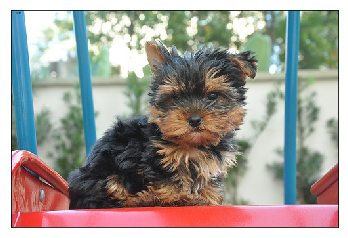

Top probabilities:
   1 )  Yorkshire_terrier  [ 95.383 %]
   2 )  silky_terrier  [ 2.608 %]
   3 )  Australian_terrier  [ 1.384 %]


In [0]:
image_test = Image.open("drive/Deep Learning/HW2/images/yorkshire_terrier_104.jpg")

plt.imshow(image_test)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

img_test = transform(image_test)
predicted = resnet18(img_test.unsqueeze(0))
probs = torch.nn.functional.softmax(predicted, dim=1)
top_prob,top_index = torch.topk(probs.squeeze(),3)
print("Top probabilities:")
for i in range(3):
  index = get_array(top_index[i])
  print("  ",i+1,") ",class_idx[str(index)][1],
        " [",round(get_array(top_prob[i])*100,3),"%]")

In [0]:
from os import listdir,path

FILE_DATA = True

if FILE_DATA:
  root_path = "drive/Deep Learning/HW2/"
  pet_labels = np.load(path.join(root_path,"pet_labels_file.npy"))
  pet_features = np.load(path.join(root_path,"pet_features_file.npy"))

else:
  # Use Image.open().convert('RGB') to get around grayscale and RGBa
  # https://discuss.pytorch.org/t/grayscale-to-rgb-transform/18315/2
  
  img_files = listdir('drive/Deep Learning/HW2/images')
  
  pet_labels = []
  pet_features = []
  root_path = "drive/Deep Learning/HW2/images/"
  for i in range(len(img_files)):
    file_fracs = img_files[i].split('.')
    name_fracs = file_fracs[0].split('_')
    name_fracs = name_fracs[:-1]
    new_name = '_'
    new_name = new_name.join(name_fracs)
    pet_labels.append(new_name)
    pet_img = Image.open(path.join(root_path,img_files[i])).convert('RGB')
    if (i % 100 == 0):
      print(i,": ",img_files[i]," - ",type(pet_img)," - ",pet_img.size)
    pet_feat = get_features(pet_img)
    pet_features.append(pet_feat)

  pet_features = np.array(pet_features)
  np.save('pet_labels_file', pet_labels)
  np.save('pet_features_file', pet_features)
  
print("Loaded pet labels for",np.unique(pet_labels).size,"classes of pets.")
print("Data set :",pet_features.shape)

Loaded pet labels for 37 classes of pets.
Data set : (7389, 512)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(pet_features, pet_labels, random_state=0)

logreg = LogisticRegression(solver='sag',multi_class='ovr')
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.3f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.3f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.920
Accuracy of Logistic regression classifier on test set: 0.904


In [0]:
pet_idx = np.unique(pet_labels)

Abyssinian 0.887
Bengal 0.778
Birman 0.933
Bombay 1.0
British_Shorthair 0.851
Egyptian_Mau 0.833
Maine_Coon 0.847
Persian 0.896
Ragdoll 0.804
Russian_Blue 0.863
Siamese 0.932
Sphynx 1.0
american_bulldog 0.815
american_pit_bull_terrier 0.512
basset_hound 0.893
beagle 0.94
boxer 0.88
chihuahua 0.885
english_cocker_spaniel 0.855
english_setter 0.962
german_shorthaired 0.932
great_pyrenees 0.979
havanese 0.918
japanese_chin 0.933
keeshond 0.956
leonberger 0.975
miniature_pinscher 0.951
newfoundland 1.0
pomeranian 0.927
pug 0.958
saint_bernard 0.98
samoyed 1.0
scottish_terrier 0.956
shiba_inu 0.942
staffordshire_bull_terrier 0.718
wheaten_terrier 0.946
yorkshire_terrier 0.967


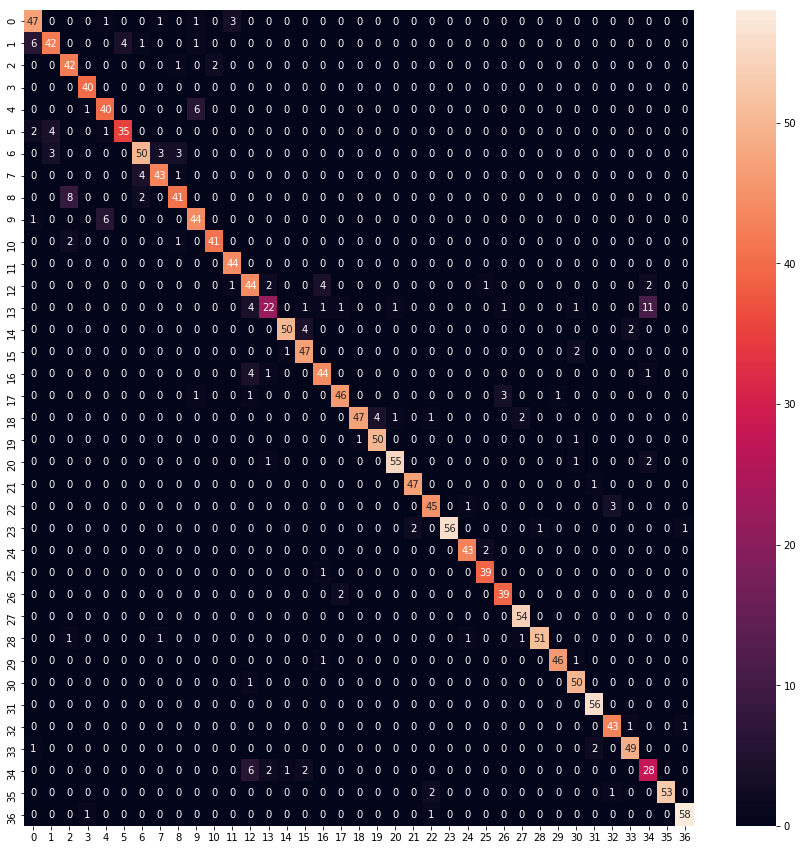

In [0]:
# Referenced the following:
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class

from sklearn.metrics import confusion_matrix
import seaborn as sn
y_pred = logreg.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)

class_acc = matrix.diagonal()/matrix.sum(axis=1)
for i in range(len(class_acc)):
  print(pet_idx[i],class_acc[i].round(3))

plt.figure(figsize=(15,15))
sn.heatmap(matrix,annot=True)
plt.savefig('transfer_matrix_heatmap')
plt.show()

# Problem 3 - Training a Small CNN

## Part 1

In [2]:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170262528/170498071 [00:19<00:00, 9648901.04it/s] 

Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Understanding parameterization of conv layers
# https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
# Background on CNN:
# https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 11, padding=5)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.avgpool = nn.AvgPool2d(2, 2)
    self.fc1 = nn.Linear(128 * 8 * 8, 10)

  def forward(self, x):
    # Hidden layer 1
    x = self.conv1(x)
    #print("Hidden1: conv1 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden1: relu -> ",x.shape)
    x = self.pool(x)
    #print("Hidden1 pool -> ",x.shape)
    
    # Hidden layer 2
    #x = self.pool(F.relu(self.conv2(x)))
    x = self.conv2(x)
    #print("Hidden2: conv2 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden2: relu -> ",x.shape)
    
    # Hidden layer 3
    x = self.conv3(x)
    #print("Hidden3: conv3 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden3: relu -> ",x.shape)
    
    # Average pooling
    x = self.avgpool(x)
    #print("avgpool = ",x.shape)
    
    # Reshape to 1d
    x = x.view(-1, 128 * 8 * 8)
    #print("x.view -> ",x.shape)

    # Fully connected layer reducing output to 10 features
    x = self.fc1(x)
    #print("fc1 -> ",x.shape)
    
    return x

net = Net()

print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0004, momentum=0.75)

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
epoch_accuracy = []
for epoch in range(30):  # loop over the dataset multiple times
  print("Beginning epoch ",epoch)

  #running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    
    inputs, labels = inputs.to(device),labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    #print("Running network")
    #print("Inputs = ",inputs.shape)
    outputs = net(inputs)
    print("outputs = ",type(outputs))
    print("labels = ",type(labels))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  acc = test_accuracy_cifar(net)
  print("Accuracy = ",acc)
  epoch_accuracy.append(acc)

    # print statistics
    #running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
        #print('[%d, %5d] loss: %.3f' %
              #(epoch + 1, i + 1, running_loss / 2000))
        #running_loss = 0.0

print('Finished Training')
plt.plot(epoch_accuracy)

Beginning epoch  0
labels =  tensor([7, 6, 4, 6])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([0, 0, 8, 7])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([6, 4, 8, 9])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([9, 6, 1, 4])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([4, 3, 6, 8])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([1, 3, 3, 4])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([2, 6, 5, 2])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([5, 8, 4, 1])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([8, 5, 9, 9])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
labels =  tensor([2, 5, 0, 2])
outputs =  <class 'torch.Tensor'>
labels =  <class 'torch.Tensor'>
l

KeyboardInterrupt: ignored

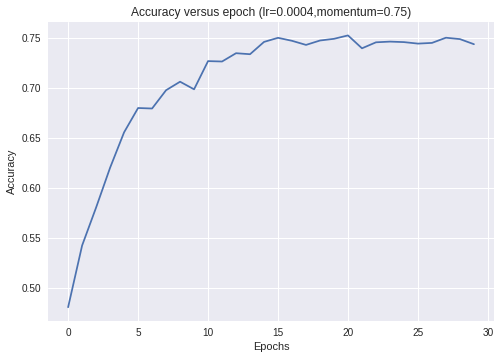

In [0]:
plt.plot(epoch_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch (lr=0.0004,momentum=0.75)")
plt.savefig('prob3_lr0004_mom075.jpg')
plt.show()

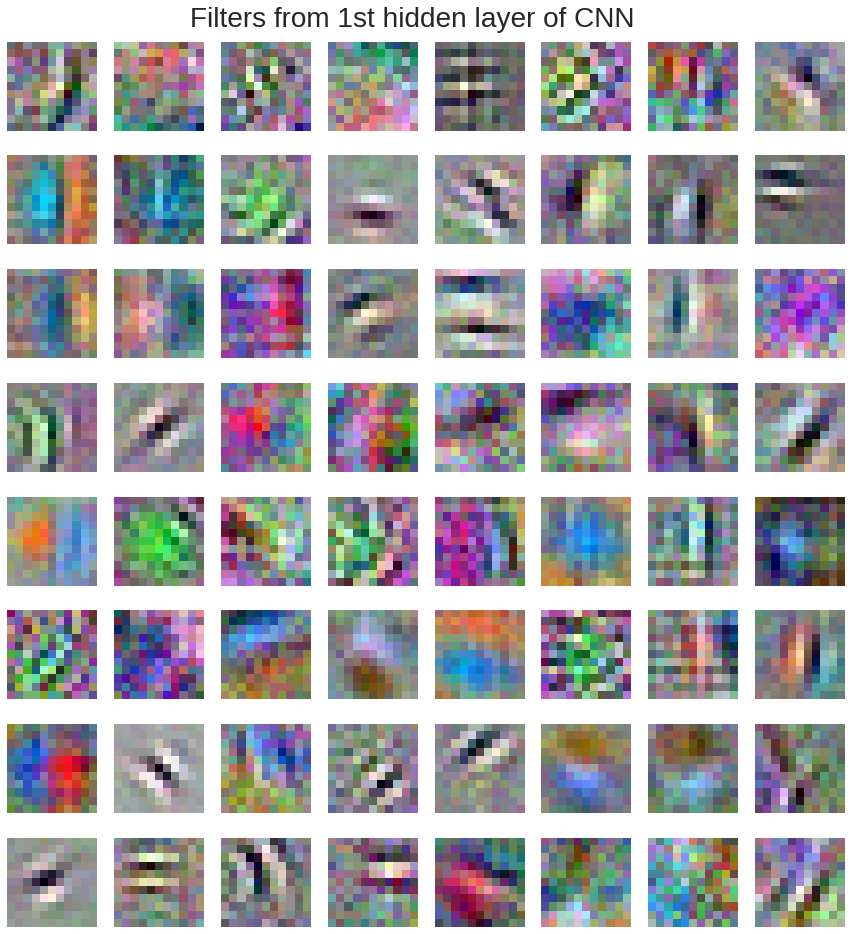

In [0]:
def print_filters(network):
  conv1_filters = network.conv1.weight.detach().cpu().numpy()
  conv1_filters = conv1_filters / 2 + 0.5

  plt.subplots(8,8,figsize=(15,15))
  plt.suptitle("Filters from 1st hidden layer of CNN",fontsize=28)

  for idx,filter in enumerate(conv1_filters):
    filter -= filter.min()
    filter /= filter.max()
    plt.subplot(8,8,idx+1)
    plt.imshow(filter.T)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.subplots_adjust(top=.95)
  plt.savefig('prob3_cnn_filters')
  plt.show()
  
print_filters(net)

In [0]:
from sklearn.metrics import accuracy_score

def get_array(tensor):
  return tensor.detach().numpy()[()]

def test_accuracy_cifar(network):
  correct = 0
  total = 0
  for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data
    inputs = inputs.to(device)
    network = network.to(device)
    outputs = get_array(network(inputs).cpu())
    labels = get_array(labels)
    for idx,output in enumerate(outputs):
      total += 1
      if labels[idx] == output.argmax():
        correct += 1
  acc = correct/total
  return acc
    
print(test_accuracy_cifar(net))

0.4887


In [0]:
testloader.dataset.classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

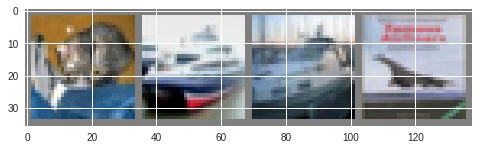

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [0]:
from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images).cpu())
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [0]:
!pip install pycuda
import pycuda.driver as cuda
cuda.init()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print(cuda.Device(0).name())


    100% |████████████████████████████████| 1.6MB 16.5MB/s 
    100% |████████████████████████████████| 61kB 21.1MB/s 
    100% |████████████████████████████████| 573kB 30.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/a5/17/ac/99922221c732eeece43529d3e0f9d441f7301c75990b2cdbff
  Stored in directory: /root/.cache/pip/wheels/1b/f4/26/46b6cf949b3cccefcc41e6b526f7c16351a4a5c124fc6f6eaa
  Stored in directory: /root/.cache/pip/wheels/15/35/25/dbcb848832ccb1a4b4ad23f529badfd3bce9bf88017f7ca510
Successfully built pycuda pytools mako
cuda:0
Tesla K80


## Part 2

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Understanding parameterization of conv layers
# https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
# Background on CNN:
# https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

class NormNet(nn.Module):
  def __init__(self):
    super(NormNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 11, padding=5)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(128)
    self.pool = nn.MaxPool2d(2, 2)
    self.avgpool = nn.AvgPool2d(2, 2)
    self.fc1 = nn.Linear(128 * 8 * 8, 10)

  def forward(self, x):
    # Hidden layer 1
    x = self.conv1(x)
    #print("Hidden1: conv1 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden1: relu -> ",x.shape)
    x = self.pool(x)
    #print("Hidden1 pool -> ",x.shape)
    
    # Hidden layer 2
    #x = self.pool(F.relu(self.conv2(x)))
    x = self.bn1(x)
    x = self.conv2(x)
    #print("Hidden2: conv2 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden2: relu -> ",x.shape)
    
    # Hidden layer 3
    x = self.bn2(x)
    x = self.conv3(x)
    #print("Hidden3: conv3 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden3: relu -> ",x.shape)
    
    # Average pooling
    x = self.avgpool(x)
    #print("avgpool = ",x.shape)
    
    # Reshape to 1d
    x = x.view(-1, 128 * 8 * 8)
    #print("x.view -> ",x.shape)

    # Fully connected layer reducing output to 10 features
    x = self.fc1(x)
    #print("fc1 -> ",x.shape)
    
    return x

normnet = NormNet()

print(normnet)

NormNet(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
norm_optimizer = optim.SGD(normnet.parameters(), lr=0.0006, momentum=0.8)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
normnet.to(device)
epoch_accuracy = []
for epoch in range(30):  # loop over the dataset multiple times
  print("Beginning epoch ",epoch)

  #running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device),labels.to(device)

    # zero the parameter gradients
    norm_optimizer.zero_grad()

    # forward + backward + optimize
    #print("Running network")
    #print("Inputs = ",inputs.shape)
    outputs = normnet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    norm_optimizer.step()

  acc = test_accuracy_cifar(normnet)
  print("Accuracy = ",acc)
  epoch_accuracy.append(acc)

print('Finished Training')

plt.plot(epoch_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch (lr=0.0006,momentum=0.8) with batch norm")
plt.savefig('prob3_lr0006_mom08_bn.jpg')
plt.show()

Beginning epoch  0
Accuracy =  0.6129
Beginning epoch  1
Accuracy =  0.6696
Beginning epoch  2
Accuracy =  0.7109
Beginning epoch  3
Accuracy =  0.7242
Beginning epoch  4
Accuracy =  0.7368
Beginning epoch  5
Accuracy =  0.7489
Beginning epoch  6
Accuracy =  0.7444
Beginning epoch  7
Accuracy =  0.74
Beginning epoch  8
Accuracy =  0.7478
Beginning epoch  9
Accuracy =  0.7474
Beginning epoch  10
Accuracy =  0.7493
Beginning epoch  11
Accuracy =  0.7468
Beginning epoch  12
Accuracy =  0.7496
Beginning epoch  13
Accuracy =  0.7587
Beginning epoch  14
Accuracy =  0.7493
Beginning epoch  15
Accuracy =  0.753
Beginning epoch  16
Accuracy =  0.7562
Beginning epoch  17
Accuracy =  0.7459
Beginning epoch  18
Accuracy =  0.7457
Beginning epoch  19
Accuracy =  0.7531
Beginning epoch  20
Accuracy =  0.75
Beginning epoch  21
Accuracy =  0.7535
Beginning epoch  22
Accuracy =  0.7534
Beginning epoch  23
Accuracy =  0.756
Beginning epoch  24
Accuracy =  0.7508
Beginning epoch  25
Accuracy =  0.7564
Be

NameError: ignored

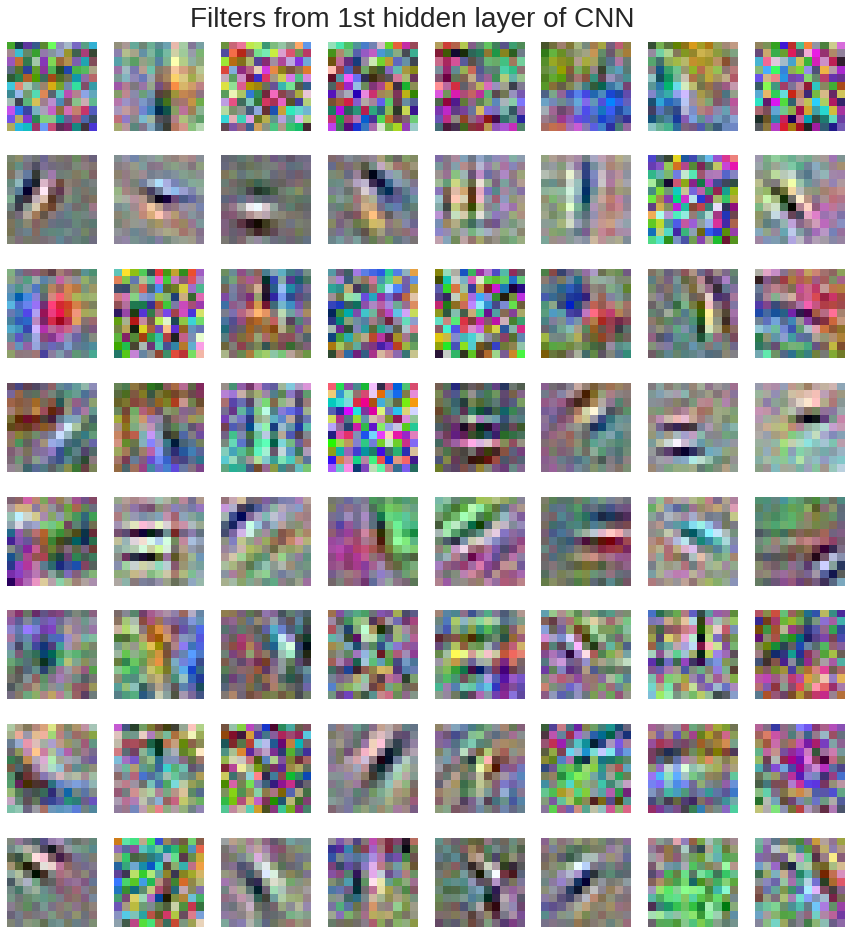

In [0]:
print_filters(normnet)

In [0]:
 test_accuracy_cifar(normnet)
  

0.757

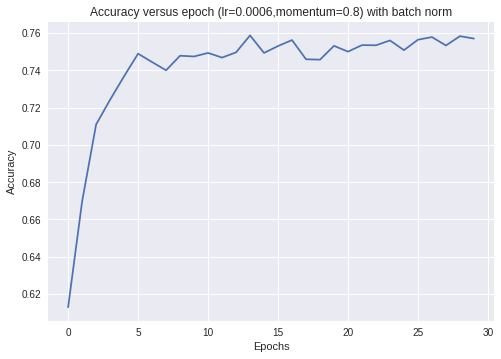

In [0]:
from matplotlib import pyplot as plt
plt.plot(epoch_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch (lr=0.0006,momentum=0.8) with batch norm")
plt.savefig('prob3_lr0006_mom08_bn.jpg')
plt.show()

## Part 3

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Understanding parameterization of conv layers
# https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
# Background on CNN:
# https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/


class NewNet(nn.Module):
  def __init__(self):
    super(NewNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 5)
    self.conv2 = nn.Conv2d(64, 128, 3)
    self.conv3 = nn.Conv2d(128, 128, 3)
    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(128)
    self.pool = nn.MaxPool2d(2, 2)
    self.avgpool = nn.AvgPool2d(2, 2)
    self.fc1 = nn.Linear(128 * 5 * 5, 512)
    self.fc2 = nn.Linear(512, 10)

  def forward(self, x):
    # Hidden layer 1
    x = self.conv1(x)
    #print("Hidden1: conv1 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden1: relu -> ",x.shape)
    x = self.pool(x)
    #print("Hidden1 pool -> ",x.shape)
    
    # Hidden layer 2
    #x = self.pool(F.relu(self.conv2(x)))
    x = self.bn1(x)
    x = self.conv2(x)
    #print("Hidden2: conv2 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden2: relu -> ",x.shape)
    
    # Hidden layer 3
    x = self.bn2(x)
    x = self.conv3(x)
    #print("Hidden3: conv3 -> ",x.shape)
    x = F.relu(x)
    #print("Hidden3: relu -> ",x.shape)
    
    # Reshape to 1d
    x = x.view(-1, 128 * 5 * 5)
    #print("x.view -> ",x.shape)

    # Fully connected layer reducing output to 10 features
    x = self.fc1(x)
    #print("fc1 -> ",x.shape)
    x = self.fc2(x)
    
    return x

newnet = NewNet()

print(newnet)

NewNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
new_optimizer = optim.SGD(newnet.parameters(), lr=0.0004, momentum=0.75)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
newnet.to(device)
epoch_accuracy = []
for epoch in range(30):  # loop over the dataset multiple times
  print("Beginning epoch ",epoch)

  #running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device),labels.to(device)

    # zero the parameter gradients
    new_optimizer.zero_grad()

    outputs = newnet(inputs)
    print("outputs = ",type(outputs),outputs.shape,outputs)
    print("labels = ",type(labels),labels.shape,labels)
    loss = criterion(outputs, labels)
    loss.backward()
    new_optimizer.step()

  acc = test_accuracy_cifar(newnet)
  print("Accuracy = ",acc)
  epoch_accuracy.append(acc)

print('Finished Training')

plt.plot(epoch_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy versus epoch (lr=0.0004,momentum=0.75) with new net")
plt.savefig('prob3_lr0004_mom075_new.jpg')
plt.show()

Beginning epoch  0
outputs =  <class 'torch.Tensor'> torch.Size([4, 10]) tensor([[ -5.8388,  -6.4443,  -4.2098,  17.0634,   5.4531,   6.1591,  -1.2780,
           0.8441,  -9.8763,  -1.4998],
        [-10.0388,  -9.0810,  -6.0949,   3.9651,   7.9662,   8.1027,  -5.5807,
          17.2160,  -8.5672,   2.7557],
        [ -2.2559,  -3.5466,   5.5554,   9.7800,   1.4415,   4.0874,   1.2388,
          -2.6661,  -9.6268,  -3.5802],
        [  8.1643,  -0.0670,   0.3897,  -0.4498,  24.0686,  -9.8441, -19.0864,
           3.3963,  -2.9413,  -3.1978]], device='cuda:0',
       grad_fn=<AddmmBackward>)
labels =  <class 'torch.Tensor'> torch.Size([4]) tensor([3, 7, 3, 4], device='cuda:0')
outputs =  <class 'torch.Tensor'> torch.Size([4, 10]) tensor([[  5.3403,  27.1592,  -9.7424,  -3.9400,  -4.0461,  -3.5804,  -0.2487,
         -16.4534,  -8.0566,  14.4780],
        [ -1.8461,   1.2284,  17.1065,   4.8816,  -1.5461,  -0.1306,  -5.9490,
          -3.6792,  -8.2989,  -1.9673],
        [ -6.0355,  -1

KeyboardInterrupt: ignored

In [0]:
print( test_accuracy_cifar(newnet))

0.7597


# Problem 4 - Fooling Convolutional Neural Networks

## Part 1

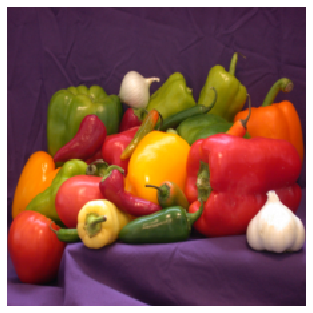

(396, 576, 3)
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.Image.Image'>


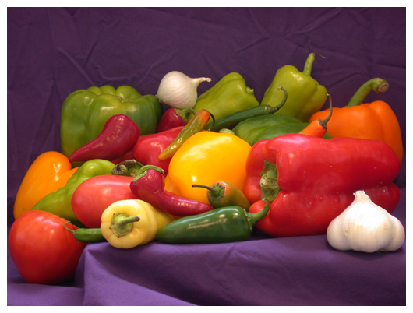

Top probabilities:
   1 )  bell_pepper  [ 95.846 %]
   2 )  cucumber  [ 1.353 %]
   3 )  orange  [ 0.503 %]


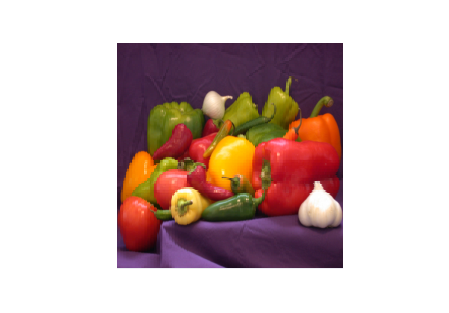

Top probabilities:
   1 )  orange  [ 24.178 %]
   2 )  Granny_Smith  [ 20.706 %]
   3 )  lemon  [ 13.085 %]


In [0]:
# Loading packages and pre-trained model with classes
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torch
from torch import nn
import numpy as np
import json
import matplotlib.pyplot as plt

resnet18 = models.resnet18(pretrained=True).eval()
with open('drive/Deep Learning/HW2/imagenet_class_index.json') as data_file:    
    class_idx = json.load(data_file)
    
image = Image.open("drive/Deep Learning/HW2/hw2/peppers.jpg")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



def print_img_tensor(img_tensor, filename="test", width=224, height=224):
  # Retransform to undo normalization for ResNet18 images
  retransform = transforms.Compose([
      transforms.Normalize(mean = [ 0., 0., 0. ],
                           std = [ 1/0.229, 1/0.224, 1/0.225 ]),
      transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                           std = [ 1., 1., 1. ]),
      transforms.ToPILImage()
      ])

  image = retransform(img_tensor)
  resizer = transforms.Resize((height, width))
  image = resizer(image)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.savefig(filename)
  plt.show()

def get_array(tensor):
  return tensor.detach().numpy()[()]


img_tensor = transform(image)
print_img_tensor(img_tensor, "test")

def print_prediction(image):
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
  ])
  
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  
  img_tensor = transform(image)
  predicted = resnet18(img_tensor.unsqueeze(0))
  probs = torch.nn.functional.softmax(predicted, dim=1)
  top_prob,top_index = torch.topk(probs.squeeze(),3)
  print("Top probabilities:")
  for i in range(3):
    index = get_array(top_index[i])
    print("  ",i+1,") ",class_idx[str(index)][1],
          " [",round(get_array(top_prob[i])*100,3),"%]")
    

adv_image = Image.open("Peppers_adversarial.png")
adv_image = adv_image.convert('RGB')
temp = np.asarray(adv_image)
print(temp.shape)

print(type(image))
print(type(adv_image))

print_prediction(image)
print_prediction(adv_image)


Predicted class - 812 [ 0.12261291 ]
Predicted class - 812 [ 0.627061 ]
Predicted class - 812 [ 0.8452039 ]


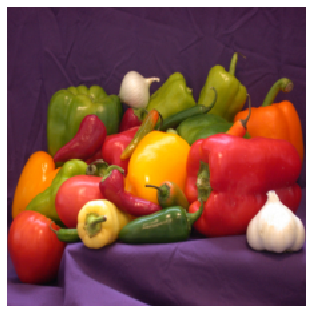

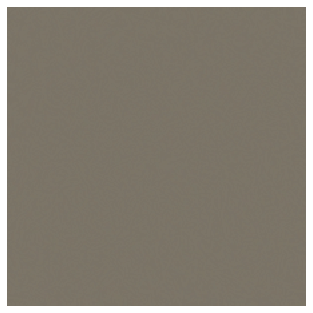

In [0]:
resnet18 = models.resnet18(pretrained=True).eval()
with open('drive/Deep Learning/HW2/imagenet_class_index.json') as data_file:    
    class_idx = json.load(data_file)
    
image = Image.open("drive/Deep Learning/HW2/hw2/peppers.jpg")

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
  )
])

criterion = nn.CrossEntropyLoss()

def create_adversarial(net, img, target_class, epsilon, lam = 0.05):
  def valid_prediction(pred_tensor, target, confidence, debug=False):
    probs = torch.nn.functional.softmax(predicted, dim=1)
    top_prob,top_index = torch.topk(probs.squeeze(),1)
    prob = top_prob.detach().numpy()[0]
    index = top_index.detach().numpy()[0]
    if debug:
      print("Predicted class -",index,"[",prob,"]")
    if target == index and prob >= confidence:
      return True
    return False
    
  # Create image tensor from image
  img_tensor = transform(img).unsqueeze(0)  
  noise = torch.tensor(np.zeros_like(img_tensor.data))
  
  # Enforce gradient being required for predicted tensor
  img_tensor.requires_grad=True
  img_tensor.grad = None

  # Predict value from image tensor using trained network
  predicted = net(img_tensor)
  target_class = torch.tensor(target_class).unsqueeze(0)
  run_count = 0
  while valid_prediction(predicted,target_class,.9) == False:
    # Zero the gradient for the network
    net.zero_grad()
    # Run backward pass on network    
    loss = criterion(predicted, target_class)
    loss.backward()
    new_noise = (epsilon * lam) * torch.sign(img_tensor.grad.data)
    noise += new_noise
    noise = torch.clamp(noise,-epsilon,epsilon)
    predicted = net(img_tensor-noise)
    run_count += 1
    if run_count % 100 == 0:
      valid_prediction(predicted,target_class,.9,True)
    
  return (img_tensor.sub(noise)).squeeze(),noise.squeeze()
  
adv_img, adv_noise = create_adversarial(resnet18, image, 812, 0.015, 0.015)
print_img_tensor(adv_img,"latest_adversarial.jpg")
print_img_tensor(adv_noise,"latest_noise.jpg")

# https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8
# http://neuralnetworksanddeeplearning.com/chap2.html
# https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/

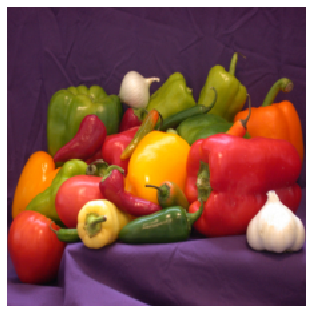

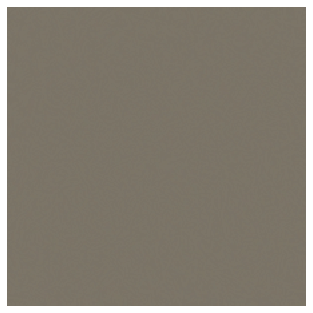

In [0]:
print_img_tensor(adv_img.squeeze(),"Peppers_adversarial")
print_img_tensor(adv_noise.squeeze(),"Peppers_noise")

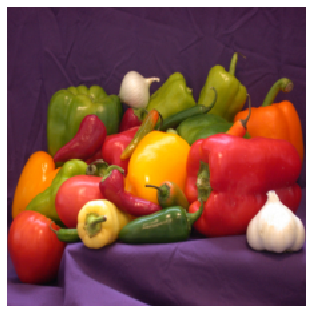

Top probabilities:
   1 )  space_shuttle  [ 90.03 %]
   2 )  balloon  [ 1.275 %]
   3 )  candle  [ 0.805 %]


In [0]:
def print_prediction_tensor(image):
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
  ])
  
  predicted = resnet18(image.unsqueeze(0))
  probs = torch.nn.functional.softmax(predicted, dim=1)
  top_prob,top_index = torch.topk(probs.squeeze(),3)
  print_img_tensor(image)
  print("Top probabilities:")
  for i in range(3):
    index = get_array(top_index[i])
    print("  ",i+1,") ",class_idx[str(index)][1],
          " [",round(get_array(top_prob[i])*100,3),"%]")

print_prediction_tensor(adv_img)


Top probabilities:
   1 )  bell_pepper  [ 95.846 %]
   2 )  cucumber  [ 1.353 %]
   3 )  orange  [ 0.503 %]
Predicted class - 812 [ 0.12261291 ]
Predicted class - 812 [ 0.627061 ]
Predicted class - 812 [ 0.8452039 ]
Top probabilities:
   1 )  school_bus  [ 99.987 %]
   2 )  passenger_car  [ 0.012 %]
   3 )  trolleybus  [ 0.0 %]
Predicted class - 574 [ 0.8355739 ]
Top probabilities:
   1 )  Chihuahua  [ 93.907 %]
   2 )  Pembroke  [ 1.375 %]
   3 )  dingo  [ 1.327 %]
Predicted class - 151 [ 0.77555996 ]
Predicted class - 151 [ 0.49096233 ]
Predicted class - 151 [ 0.24739128 ]
Predicted class - 151 [ 0.11910067 ]
Predicted class - 934 [ 0.097056545 ]
Predicted class - 934 [ 0.22457618 ]
Predicted class - 934 [ 0.3850047 ]
Predicted class - 934 [ 0.4971102 ]
Predicted class - 934 [ 0.5997641 ]
Predicted class - 934 [ 0.6864246 ]
Predicted class - 934 [ 0.7571117 ]
Predicted class - 934 [ 0.80798656 ]
Predicted class - 934 [ 0.8444963 ]
Predicted class - 934 [ 0.87188345 ]
Predicted class 

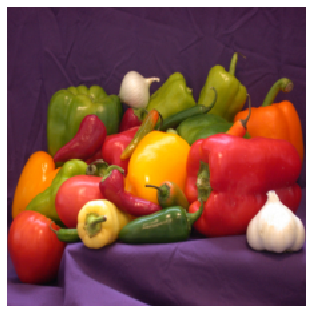

Top probabilities:
   1 )  space_shuttle  [ 90.03 %]
   2 )  balloon  [ 1.275 %]
   3 )  candle  [ 0.805 %]


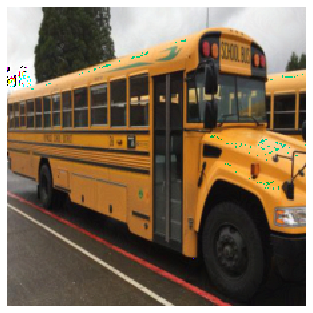

Top probabilities:
   1 )  golf_ball  [ 90.431 %]
   2 )  school_bus  [ 1.339 %]
   3 )  passenger_car  [ 0.434 %]


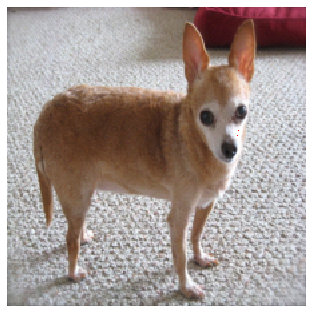

Top probabilities:
   1 )  hotdog  [ 90.001 %]
   2 )  Chihuahua  [ 1.094 %]
   3 )  Pembroke  [ 0.546 %]


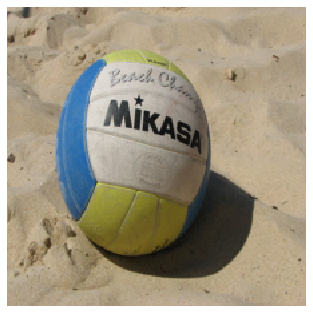

Top probabilities:
   1 )  volcano  [ 90.017 %]
   2 )  sandbar  [ 1.268 %]
   3 )  alp  [ 0.758 %]


In [0]:
orig_images = []
orig_images.append(Image.open("drive/Deep Learning/HW2/hw2/peppers.jpg"))
orig_images.append(Image.open("drive/Deep Learning/HW2/schoolbus.jpg"))
orig_images.append(Image.open("drive/Deep Learning/HW2/images/chihuahua_12.jpg"))
orig_images.append(Image.open("drive/Deep Learning/HW2/volleyball.jpg"))

noise_images = []
adv_images = []

targets = [812,574,934,980]
epsilon = [0.015,0.03,0.02,0.05]
lams = [0.015,0.019,0.0015,0.02]

for idx,image in enumerate(orig_images):
  print_prediction(image)
  adv_img, adv_noise = create_adversarial(resnet18, image, targets[idx], epsilon[idx], lams[idx])
  noise_images.append(adv_noise)
  adv_images.append(adv_img)
  
for image in adv_images:
  print_prediction_tensor(image)

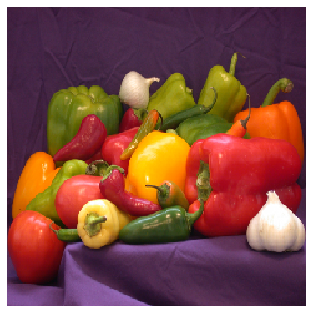

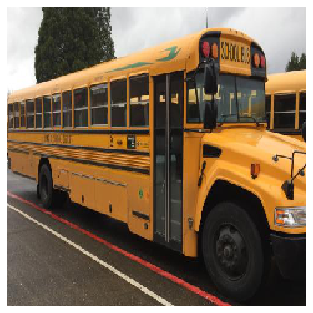

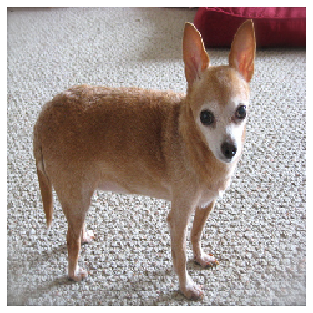

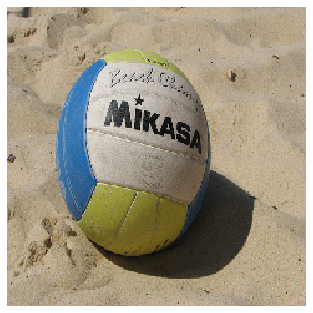

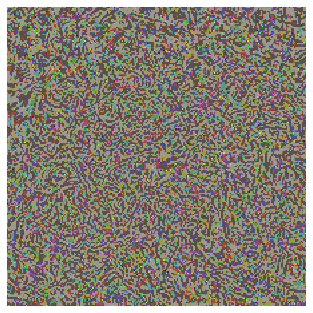

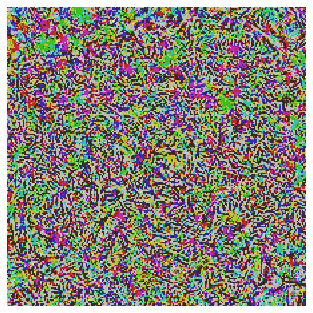

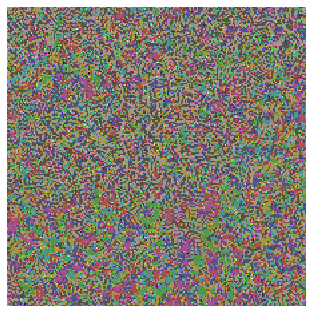

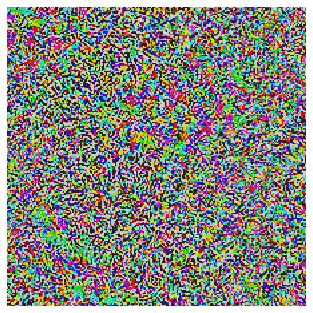

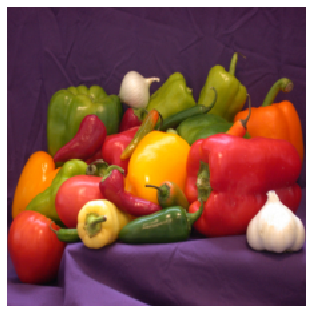

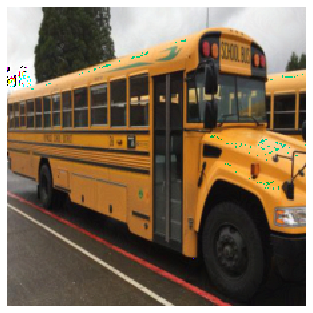

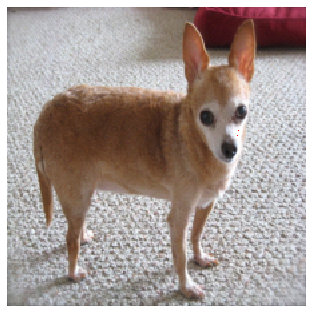

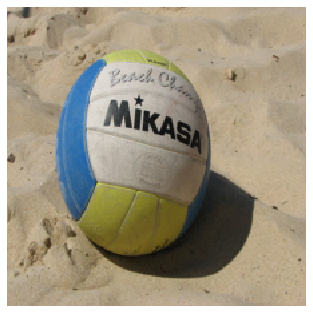

In [0]:
for i in orig_images:
  plt.imshow(i.resize((240,240)))
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  
for i in noise_images:
  print_img_tensor(i*255)
  
for i in adv_images:
  print_img_tensor(i)

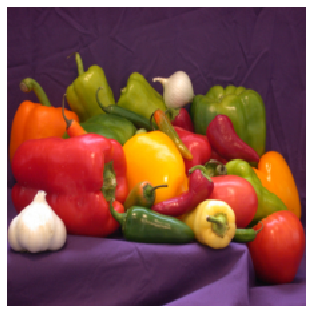

Top probabilities:
   1 )  bell_pepper  [ 97.17 %]
   2 )  orange  [ 0.494 %]
   3 )  lemon  [ 0.484 %]


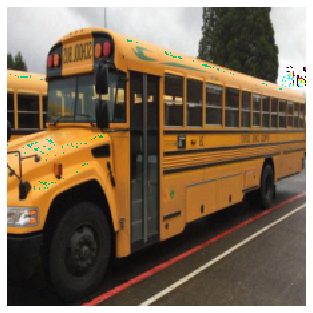

Top probabilities:
   1 )  school_bus  [ 99.991 %]
   2 )  passenger_car  [ 0.007 %]
   3 )  trolleybus  [ 0.001 %]


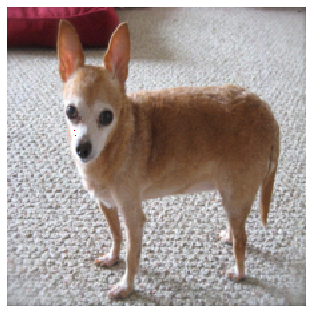

Top probabilities:
   1 )  Chihuahua  [ 90.687 %]
   2 )  Pembroke  [ 2.39 %]
   3 )  dingo  [ 2.234 %]


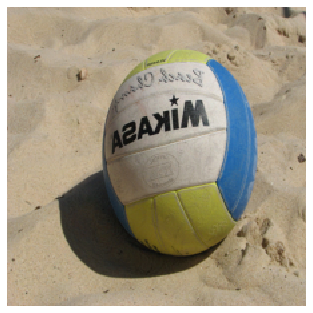

Top probabilities:
   1 )  volleyball  [ 95.532 %]
   2 )  soccer_ball  [ 2.138 %]
   3 )  rugby_ball  [ 1.699 %]


In [0]:
import torchvision
retransform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                         std = [ 1., 1., 1. ]),
    transforms.ToPILImage()
    ])

to_image = torchvision.transforms.ToPILImage()
for idx,i in enumerate(adv_images):
  img = retransform(i)
  img = torchvision.transforms.functional.hflip(img)
  print_prediction(img)


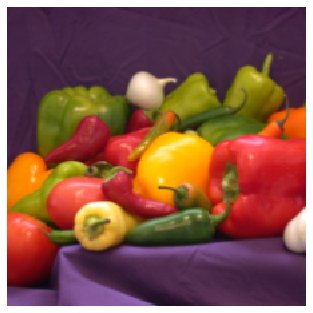

Top probabilities:
   1 )  bell_pepper  [ 88.398 %]
   2 )  cucumber  [ 3.771 %]
   3 )  grocery_store  [ 1.908 %]


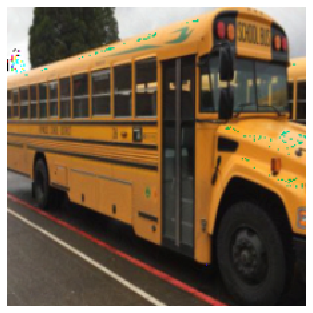

Top probabilities:
   1 )  school_bus  [ 99.895 %]
   2 )  passenger_car  [ 0.072 %]
   3 )  trolleybus  [ 0.025 %]


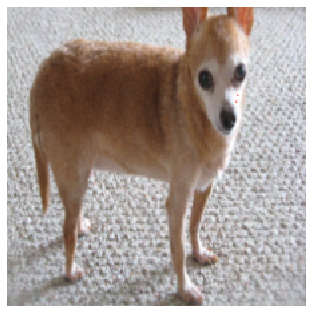

Top probabilities:
   1 )  Chihuahua  [ 57.453 %]
   2 )  dingo  [ 6.205 %]
   3 )  Pembroke  [ 2.625 %]


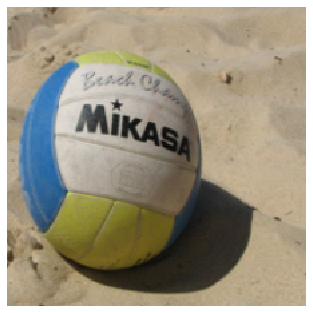

Top probabilities:
   1 )  volleyball  [ 91.963 %]
   2 )  soccer_ball  [ 4.525 %]
   3 )  tennis_ball  [ 1.841 %]


In [0]:
import torchvision
retransform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                         std = [ 1., 1., 1. ]),
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 0.8))
    ])

to_image = torchvision.transforms.ToPILImage()
for idx,i in enumerate(adv_images):
  img = retransform(i)
  print_prediction(img)


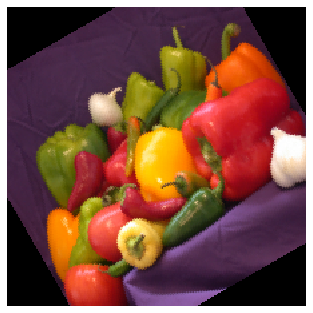

Top probabilities:
   1 )  bell_pepper  [ 74.569 %]
   2 )  orange  [ 5.647 %]
   3 )  strawberry  [ 5.09 %]


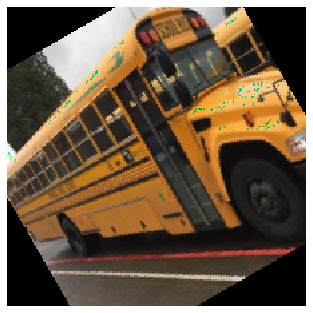

Top probabilities:
   1 )  school_bus  [ 52.408 %]
   2 )  wallet  [ 8.877 %]
   3 )  cab  [ 8.699 %]


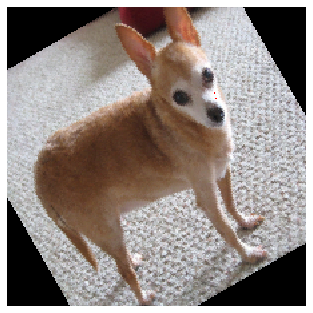

Top probabilities:
   1 )  Chihuahua  [ 46.591 %]
   2 )  Pembroke  [ 5.75 %]
   3 )  dingo  [ 5.44 %]


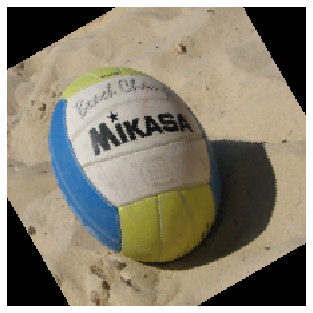

Top probabilities:
   1 )  tennis_ball  [ 65.571 %]
   2 )  volleyball  [ 14.383 %]
   3 )  rugby_ball  [ 11.461 %]


In [0]:
import torchvision
retransform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                         std = [ 1., 1., 1. ]),
    transforms.ToPILImage()
    ])

to_image = torchvision.transforms.ToPILImage()
for idx,i in enumerate(adv_images):
  img = retransform(i)
  img = torchvision.transforms.functional.rotate(img,30)
  print_prediction(img)


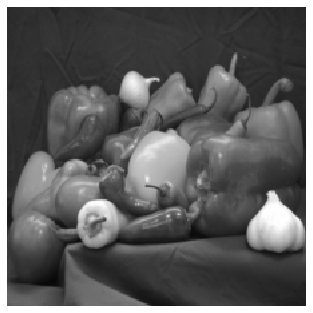

Top probabilities:
   1 )  piggy_bank  [ 34.698 %]
   2 )  butternut_squash  [ 13.166 %]
   3 )  nipple  [ 6.293 %]


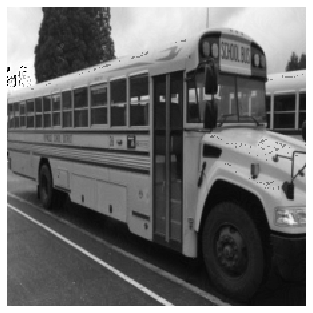

Top probabilities:
   1 )  passenger_car  [ 32.219 %]
   2 )  school_bus  [ 28.715 %]
   3 )  recreational_vehicle  [ 9.719 %]


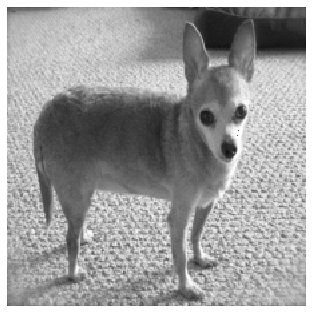

Top probabilities:
   1 )  coyote  [ 29.618 %]
   2 )  wallaby  [ 14.649 %]
   3 )  Chihuahua  [ 9.104 %]


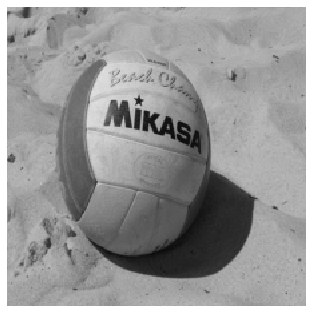

Top probabilities:
   1 )  rugby_ball  [ 17.481 %]
   2 )  soccer_ball  [ 14.386 %]
   3 )  volleyball  [ 8.163 %]


In [0]:
import torchvision
retransform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                         std = [ 1., 1., 1. ]),
    transforms.ToPILImage()
    ])

to_image = torchvision.transforms.ToPILImage()
for idx,i in enumerate(adv_images):
  img = retransform(i)
  img = torchvision.transforms.functional.to_grayscale(img,num_output_channels=3)
  print_prediction(img)


In [0]:
f, axarr = plt.subplots(4, 3)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 2].imshow
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')